Step back prompting来自论文《Take A Step Back: Evoking Reasoning Via Abstraction In Large Language Models》

Step back prompting是谷歌deepmind开发的一种方法，它首先使用LLM创建用户查询的抽象（从用户具体查询到通用查询的转换，因此称为后退提示），然后根据生成的通用查询来生成答案。

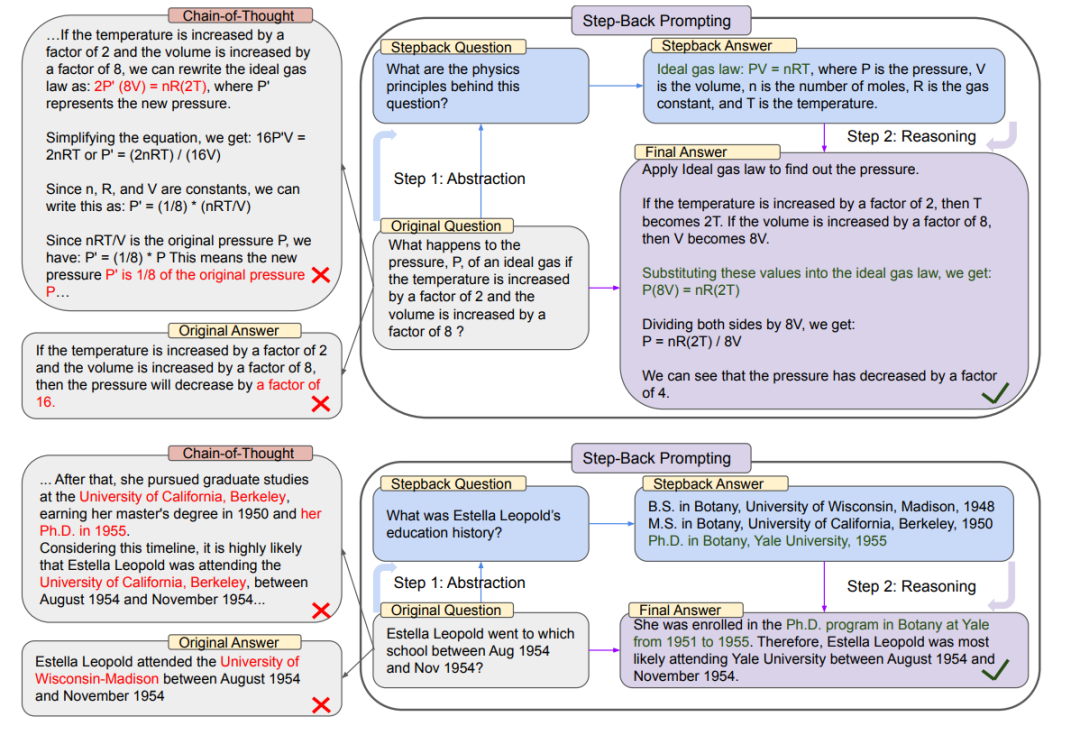

以下是“原始查询”和“后退查询”的示例：

{    "Original_Query": "Could the members of The Police perform lawful arrests?",    "Step_Back_Query": "what can the members of The Police do?",},

{    "Original_Query": "Jan Sindel’s was born in what country?",    "Step_Back_Query": "what is Jan Sindel’s personal history?",}

In [1]:
!pip install langchain langchain_community openai chromadb tiktoken langchainhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#---------------------Prepare VectorDB-----------------------------------
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
import os

In [3]:
# 设置OpenAI KEY环境变量
import os
import getpass
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

OpenAI API Key:··········


In [8]:
# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

#-------------------Prepare Step Back Prompt Pipeline------------------------
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chat_models import ChatOpenAI

retriever = vectordb.as_retriever()
llm = ChatOpenAI()

# Few Shot Examples
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]

# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

question_gen = prompt | llm | StrOutputParser()

#--------------------------QnA using Back Prompt Technique-----------------
from langchain import hub

def format_docs(docs):
    doc_strings = [doc.page_content for doc in docs]
    return "\n\n".join(doc_strings)

response_prompt = hub.pull("langchain-ai/stepback-answer")

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever | format_docs,
        # Retrieve context using the step-back question
        "step_back_context": question_gen | retriever | format_docs,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | llm
    | StrOutputParser()
)

result = chain.invoke({"question": "What Task Decomposition that work in 2022?"})

In [9]:
result

'Task decomposition is a method used in project management and software development to break down complex tasks or projects into smaller, more manageable subtasks. In 2022, there are several task decomposition techniques that are commonly used in various industries to improve efficiency and productivity.\n\nOne popular task decomposition method is the Work Breakdown Structure (WBS), which involves breaking down a project into smaller, more manageable tasks, known as work packages. Each work package is then assigned to a team or individual for completion, helping to streamline the project management process and ensure that all tasks are completed on time.\n\nAnother common task decomposition technique is the Agile Sprint Planning, which is often used in software development projects. In this method, the project is broken down into smaller iterations, known as sprints, with specific goals and tasks assigned to each sprint. This approach allows for more flexibility and adaptability in the